In [59]:
import pandas as pd
import numpy as np
import sqlalchemy as sqla
import plotnine as p9
import matplotlib.pyplot as plt
from io import StringIO
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#establish connection to database
conn = sqla.create_engine('sqlite:///yelp.sqlite')


 # Business Analysis

In [2]:
business = pd.read_sql_query("""
                         select business.*, attributes.RestaurantsPriceRange2
                         from business, attributes
                         where business.business_id = attributes.business_id """, conn)


## Dependencey between price/stars

In [126]:

df_price = business.copy()
df_price = df_price[df_price['RestaurantsPriceRange2'].notnull()]

tab = pd.crosstab(df_price['stars'],df_price['RestaurantsPriceRange2'])
tab = tab.loc[:,["1", "2", "3", "4"]]
table = sm.stats.Table(tab)
# print(table.table_orig)
# print(table.fittedvalues)
# print(table.resid_pearson)
# rslt = table.test_nominal_association()
# print(rslt.pvalue)


In [128]:
table_count = pd.crosstab(df_price.stars, df_price.RestaurantsPriceRange2).\
                    replace(0,np.nan).stack().reset_index().rename(columns={0:'Counts'})

# p9.ggplot(table_count, p9.aes('stars','RestaurantsPriceRange2', fill = 'Counts')) + \
#     p9.geom_tile(p9.aes(),color="black") + \
#     p9.geom_text(p9.aes(label = 'Counts'), size = 9)  +\
#     p9.scale_fill_gradient(low = "white", high = "Orange") +\
#     p9.theme_minimal(base_size = 15)  +\
#     p9.labs(title = "Restaurants's Stars with corresponding Price level ",y ="Price Level ",       x = "Stars")

In [10]:

df_1star = test.loc[test['stars'] == 1]
wc = WordCloud()

In [33]:
counts = test["city"].value_counts()[0:10]
top_10_city = pd.DataFrame(counts).reset_index()

top_10_city.columns = ['City','Counts']
# top_10_city
# p9.ggplot(top_10_city) + p9.geom_bar(p9.aes(x = 'City',fill = 'Counts'),
# position = "stack",alpha=0.4)

In [18]:
list(test.columns.values)

['business_id',
 'address',
 'categories',
 'city',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'neighborhood',
 'postal_code',
 'review_count',
 'stars',
 'state',
 'RestaurantsPriceRange2']

##  10 most reviews 

In [12]:
business[['name','review_count','city','stars']].sort_values(ascending = False, by = 'review_count')[0:10]

,name,review_count,city,stars
118888,Mon Ami Gabi,7968,Las Vegas,4.0
159820,Bacchanal Buffet,7866,Las Vegas,4.0
54163,Wicked Spoon,6446,Las Vegas,3.5
162552,Gordon Ramsay BurGR,5472,Las Vegas,4.0
146892,Hash House A Go Go,5382,Las Vegas,4.0
153256,Earl of Sandwich,4981,Las Vegas,4.5
156670,The Buffet,4240,Las Vegas,3.5
100330,The Cosmopolitan of Las Vegas,4097,Las Vegas,4.0
116602,The Buffet at Bellagio,4091,Las Vegas,3.5
156039,Secret Pizza,4078,Las Vegas,4.0


In [20]:
check_in = pd.read_sql_query("""
                         select business.*, checkin.checkins
                         from business, checkin
                         where business.business_id = checkin.business_id """, conn)


In [4]:
check_in2 = pd.read_sql_query("""
                         select business.city, checkin.checkins,checkin.hour
                         from business, checkin
                         where business.business_id = checkin.business_id """, conn)


## Top 10 city ordered by checkin's count 

In [32]:
city2 = check_in2.groupby(['city']).sum()
tc = city2.checkins.sort_values(ascending = False)[:10]
tc = tc.to_frame().reset_index()


In [107]:
city2

,city,checkins
0,Las Vegas,6596713.0
1,Phoenix,2104624.0
2,Scottsdale,1390188.0
3,Toronto,868388.0
4,Charlotte,840886.0
5,Henderson,683771.0
6,Tempe,611692.0
7,Pittsburgh,505250.0
8,Chandler,410492.0
9,Mesa,375234.0


In [118]:
city = check_in.groupby(['city']).sum()
top_city = city.checkins.sort_values(ascending = False)[:10]
top_10_city = top_city.to_frame().reset_index()


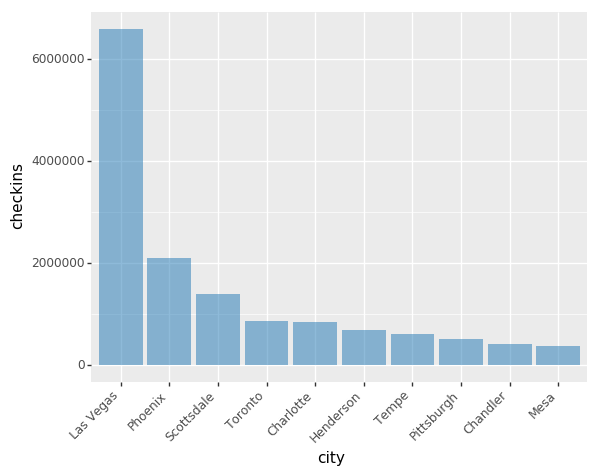

<ggplot: (-9223372029039862314)>

In [124]:
p9.ggplot(top_10_city, p9.aes(x='city', y='checkins')) + \
    p9.geom_bar(stat='identity',fill = 'C0',alpha=0.5) + \
    p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1)) +\
    p9.scale_x_discrete(limits=top_10_city.city)

## Checkin Dis'n without Las Vegas

In [103]:
non_vegas = check_in2.drop(check_in2[check_in2['city'] == 'Las Vegas'].index)
hour = non_vegas.groupby('hour')['checkins'].sum()
# hour_c = hour.to_frame().reset_index()
# hour_c['checkins'].sort_values(ascending = False)

Text(0.5, 1.0, 'Total checkin counts in 24 hours')

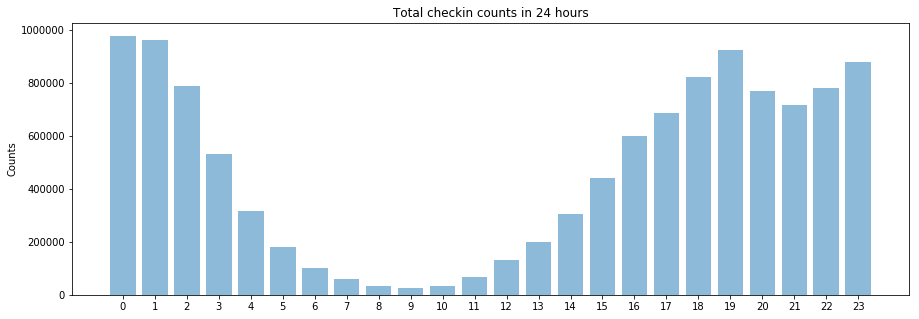

In [105]:
idx = hour.index
y_pos = np.arange(len(idx))
counts = list(hour)

fig1, axl = plt.subplots(figsize = (15,5))
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos,idx)
plt.ylabel('Counts')
plt.title('Total checkin counts in 24 hours')